In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from math import sqrt


import os,sys
import time, csv
import random
from collections import Counter

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
# from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# from rdkit.Chem.Draw import IPythonConsole
# from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import AttentiveFP

from torch_geometric.data import InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import from_smiles
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
# print(plt.style.available)
plt.style.use('ggplot')

In [4]:
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [5]:
seed_set()

In [6]:
df_final = pd.read_csv('virdis_solu_final_5.csv')

In [7]:
df_final.head()

,smiles,log_sol
0,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,-4.340860
1,C(CCl)Cl,-1.060961
2,C1=CC(=C(C=C1Cl)Cl)Cl,-3.568441
3,C1=CC(=C(C=C1Cl)O)Cl,-1.420497
4,C1=CC(=CC(=C1)O)C=O,-1.230058


In [27]:
smile = df_final['smiles'][32]
smile

'CC1=CC(=CC=C1)O'

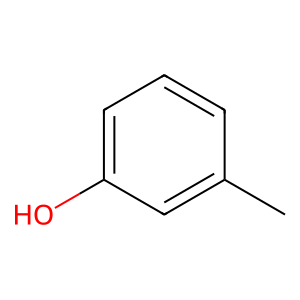

In [28]:
mol = Chem.MolFromSmiles(smile)
img = Draw.MolToImage(mol)
img

In [29]:
g = from_smiles(smile, with_hydrogen=False)
g

Data(x=[8, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles='CC1=CC(=CC=C1)O')

In [30]:
type(g)
g.x.dtype

torch.int64

In [31]:
g.x

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [8, 0, 2, 5, 1, 0, 3, 0, 0]])

In [32]:
g.num_nodes

8

In [33]:
g.num_node_features

9

In [34]:
g.edge_index

tensor([[0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7],
        [1, 0, 2, 6, 1, 3, 2, 4, 7, 3, 5, 4, 6, 1, 5, 3]])

In [35]:
g.edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1]])

In [36]:
g

Data(x=[8, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles='CC1=CC(=CC=C1)O')

In [37]:
G = to_networkx(g)

In [38]:
type(G)

networkx.classes.digraph.DiGraph

In [39]:
G.number_of_nodes()

8

In [40]:
list(G.nodes)

[0, 1, 2, 3, 4, 5, 6, 7]

In [41]:
G.number_of_edges()

16

In [42]:
list(G.edges)

[(0, 1),
 (1, 0),
 (1, 2),
 (1, 6),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (3, 7),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 1),
 (6, 5),
 (7, 3)]

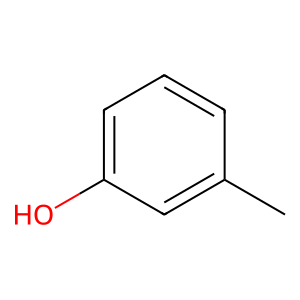

In [43]:
img

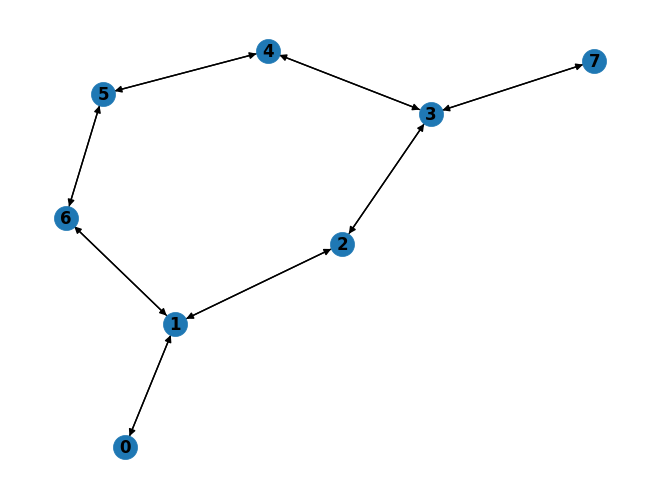

In [44]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.savefig("G.png")

In [45]:
df_final.head()

,smiles,log_sol
0,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,-4.340860
1,C(CCl)Cl,-1.060961
2,C1=CC(=C(C=C1Cl)Cl)Cl,-3.568441
3,C1=CC(=C(C=C1Cl)O)Cl,-1.420497
4,C1=CC(=CC(=C1)O)C=O,-1.230058


In [47]:
graph_list = []
for i, smile in enumerate(df_final['smiles']):
  g = from_smiles(smile)
  g.x = g.x.float()
  y = torch.tensor(df_final['log_sol'][i], dtype=torch.float).view(1, -1)
  g.y = y
  graph_list.append(g)


In [48]:
type(graph_list[0])

torch_geometric.data.data.Data

In [49]:
graph_list[1]

Data(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], smiles='C(CCl)Cl', y=[1, 1])

In [50]:
graph_list[1].y

tensor([[-1.0610]])

In [82]:
class MyDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return 'virdis_solu_final_5.csv'

    @property
    def processed_file_names(self):
        return 'data.dt'

    def download(self):
        # Download to `self.raw_dir`.
        # download_url(url, self.raw_dir)
        pass

    def process(self):
        # Read data into huge `Data` list.
        graph_list = []
        for i, smile in enumerate(df_final['smiles']):
          g = from_smiles(smile)
          g.x = g.x.float()
          y = torch.tensor(df_final['log_sol'][i], dtype=torch.float).view(1, -1)
          g.y = y
          graph_list.append(g)


        data_list = graph_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

In [83]:
virdis = MyDataset(root = '/content/')

In [84]:
type(virdis)

__main__.MyDataset

In [85]:
virdis[22]

Data(x=[13, 9], edge_index=[2, 24], edge_attr=[24, 3], smiles='CCOP(=S)(OCC)SCSCC', y=[1, 1])

In [86]:
virdis[22].y

tensor([[-4.1100]])

In [87]:
len(virdis)

1126

In [88]:
train_ratio = 0.80  # 80% for training, 20% for testing
dataset_size = len(graph_list)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into train and test subsets
generator1 = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(graph_list, [train_size, test_size], generator=generator1)

In [89]:
df_final.iloc[train_dataset.indices]

,smiles,log_sol
1926,C(CO)C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)...,-6.529910
1482,CC1=CC=C(C=C1)S(=O)(=O)C,-1.987998
606,C1=CC(=CC(=C1)N)C(F)(F)F,-1.469957
244,CC(C)N(C1=CC=CC=C1)C(=O)CCl,-2.562272
2410,C1CN(CCN1CC=CC2=CC=CC=C2)C(C3=CC=CC=C3)C4=CC=C...,-2.691376
...,...,...
448,CC(C)(C1=CC(=C(C(=C1)Br)O)Br)C2=CC(=C(C(=C2)Br...,-6.502523
1273,C1=CC=[N+](C=C1)[O-],1.021819
2335,CC(C(C)(C)C)N,0.986088
497,C1=CC(=C(C(=C1)Cl)Cl)Cl,-4.003365


In [90]:
test = df_final.iloc[test_dataset.indices]
test.to_csv('test_set.csv', index=None)

In [91]:
len(train_dataset)

2139

In [92]:
len(test_dataset)

535

In [93]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [94]:
type(train_loader)

torch_geometric.loader.dataloader.DataLoader

In [95]:
len(list(train_loader))

67

In [96]:
graph_list[0]

Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl', y=[1, 1])

In [97]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=4, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
                             weight_decay=10**-5)

In [98]:
print(model)

AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1, edge_dim=3, num_layers=4, num_timesteps=2)


In [99]:
def train():
    total_loss = total_samples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
    return sqrt(total_loss / total_samples)

In [100]:
@torch.no_grad()
def test(loader):
    mse = []
    model.eval()
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr,data.batch)
        l = F.mse_loss(out, data.y, reduction='none').cpu()
        mse.append(l)
    rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    return rmse

Epoch: 000, Train Loss: 2.0177 Test Loss: 1.8232
Epoch: 001, Train Loss: 1.6288 Test Loss: 1.5966
Epoch: 002, Train Loss: 1.3993 Test Loss: 1.4055
Epoch: 003, Train Loss: 1.2777 Test Loss: 1.2899
Epoch: 004, Train Loss: 1.2392 Test Loss: 1.1773
Epoch: 005, Train Loss: 1.1271 Test Loss: 1.1880
Epoch: 006, Train Loss: 1.0827 Test Loss: 1.1243
Epoch: 007, Train Loss: 1.0803 Test Loss: 1.0853
Epoch: 008, Train Loss: 1.0316 Test Loss: 1.0717
Epoch: 009, Train Loss: 1.0279 Test Loss: 1.0725
Epoch: 010, Train Loss: 1.0158 Test Loss: 1.0570
Epoch: 011, Train Loss: 1.0472 Test Loss: 1.0556
Epoch: 012, Train Loss: 0.9971 Test Loss: 1.0324
Epoch: 013, Train Loss: 0.9613 Test Loss: 1.0309
Epoch: 014, Train Loss: 0.9587 Test Loss: 1.0151
Epoch: 015, Train Loss: 0.9445 Test Loss: 1.0130
Epoch: 016, Train Loss: 0.9405 Test Loss: 0.9817
Epoch: 017, Train Loss: 0.9136 Test Loss: 0.9586
Epoch: 018, Train Loss: 0.9047 Test Loss: 0.9950
Epoch: 019, Train Loss: 0.9089 Test Loss: 1.1392
Epoch: 020, Train Lo

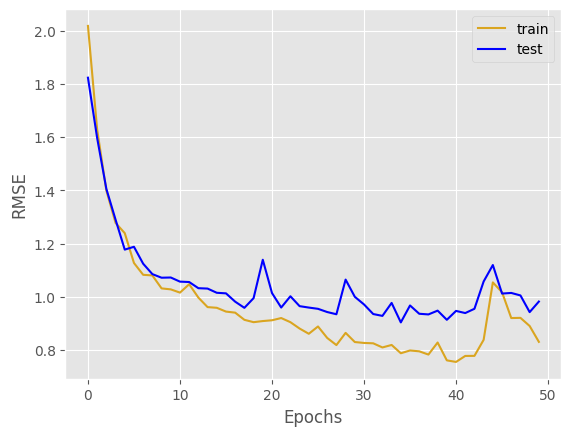

In [101]:
score_train = []
score_test = []
epochs = 50
model.reset_parameters()
for epoch in range(epochs):
    train_rmse = train()
    test_rmse = test(test_loader)
    score_train.append(train_rmse)
    score_test.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_rmse:.4f} '
          f'Test Loss: {test_rmse:.4f}')
plt.plot(range(epochs), score_train, c='goldenrod')
plt.plot(range(epochs), score_test, c = 'blue')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['train', 'test'])

In [102]:
@torch.no_grad()
def eval(loader):
    output = []
    smi = []
    model.eval()
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)
        smi.append(data.smiles)

    # Stack the tensors along batch dimension
    stacked_output = torch.cat(output, dim=0)
    stacked_smiles = np.concatenate(smi)
    results = pd.concat([pd.DataFrame(stacked_output.cpu(), columns=['pred', 'actual']), pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
    r2 = r2_score(results['actual'], results['pred'])
    print(f"The R2 score is {r2}")
    return results

In [103]:
test_res = eval(test_loader)

The R2 score is 0.8459764719009399


In [104]:
test_res.head()

,pred,actual,smiles
0,-3.387203,-4.625333,CC1=CC=C(C=C1)S(=O)(=O)C(I)I
1,-2.946919,-2.888919,C
2,-0.802988,-1.660081,CC1=C(S(=O)(=O)CCS1(=O)=O)C
3,-2.946919,-2.834912,C
4,0.585488,0.522503,C1C(C(C(C(O1)O)O)O)O


In [105]:
np.sqrt(mean_squared_error(test_res['actual'], test_res['pred']))

np.float64(0.9821391068424111)

In [106]:
train_res = eval(train_loader)

The R2 score is 0.898185133934021


In [107]:
train_res.head()

,pred,actual,smiles
0,-6.005982,-5.478860,C1=C(C(=C(C(=C1Cl)Cl)Cl)Cl)Cl
1,-3.585862,-3.488551,C1=CC=C(C=C1)C(C2=CC=C(C=C2)Cl)O
2,-7.916620,-7.950269,C1=CC(=CC=C1C2=C(C(=C(C=C2Cl)Cl)Cl)Cl)Cl
3,-2.935128,-2.194457,CCC(C)C1=CC=C(C=C1)O
4,-0.994753,-1.340781,CCCOC(=O)CC


In [108]:
np.sqrt(mean_squared_error(train_res['actual'], train_res['pred']))

np.float64(0.7758484072779582)

In [109]:
torch.save(model, '/content/model_virdis.pth')

In [110]:
model = torch.load('/content/model_virdis.pth')

/tmp/ipykernel_449/441896053.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/model_virdis.pth')


In [111]:
test_res = eval(test_loader)

The R2 score is 0.8459764719009399
